In [10]:
# --- Imports Básicos ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Imports de Statsmodels (Análise) ---
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# --- Imports do StatsForecast (Modelos Estatísticos) ---
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA

# --- Imports do TensorFlow/Keras (LSTM) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# --- Imports de Métricas de Avaliação ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Configurações de Visualização ---
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Função de Métrica SMAPE ---
def smape(y_true, y_pred):
    """ Calcula o Symmetric Mean Absolute Percentage Error (SMAPE) """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [11]:
print("\n--- Iniciando Carga e Limpeza de Dados ---")

# --- Funções de Limpeza ---
def limpar_preco(preco_str):
    """ Remove separadores de milhar ('.') de uma string """
    if isinstance(preco_str, str):
        return preco_str.replace('.', '')
    return preco_str

def converter_volume(vol_str):
    """ Converte strings de volume (ex: '8,34B', '3,74M') para números """
    vol_str = str(vol_str).strip()
    if pd.isna(vol_str):
        return np.nan
    
    # Substituir vírgula decimal por ponto decimal
    vol_str = vol_str.replace(',', '.')
    
    if 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1_000_000_000
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1_000_000
    try:
        return float(vol_str)
    except ValueError:
        return np.nan

# --- Carregar os Dados ---
try:
    # Ler o CSV, tratando colunas de preço como string para evitar conversão errada
    df = pd.read_csv(
        'dados10anos.csv', 
        dtype={'Último': str, 'Abertura': str, 'Máxima': str, 'Mínima': str}
    )
    
    # --- Aplicar Limpeza ---
    
    # 1. Converter 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
    
    # 2. Limpar e Converter colunas de Preço
    cols_preco = ['Último', 'Abertura', 'Máxima', 'Mínima']
    for col in cols_preco:
        df[col] = df[col].apply(limpar_preco)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # 3. Limpar e Converter 'Vol.'
    df['Vol.'] = df['Vol.'].apply(converter_volume)
    
    # 4. Renomear colunas
    df.rename(columns={'Data': 'ds', 'Último': 'y', 'Vol.': 'volume'}, inplace=True)
    
    # 5. Ordenar por data (essencial!)
    df.sort_values(by='ds', ascending=True, inplace=True)
    
    # 6. Definir 'ds' como índice
    df.set_index('ds', inplace=True)
    
    # 7. Selecionar colunas e tratar NaNs
    df_clean = df[['y', 'volume']].copy()
    df_clean.ffill(inplace=True) # Preencher NaNs com o valor anterior
    df_clean.dropna(inplace=True) # Remover NaNs no início (se houver)

    print("Dados carregados e limpos com sucesso.")
    print(df_clean.head())

except FileNotFoundError:
    print("Erro: Arquivo 'dados10anos.csv' não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a limpeza: {e}")


--- Iniciando Carga e Limpeza de Dados ---
Dados carregados e limpos com sucesso.
                y     volume
ds                          
2015-10-01  45313  3890000.0
2015-10-02  47033  4130000.0
2015-10-05  47598  3320000.0
2015-10-06  47735  3370000.0
2015-10-07  48914  6250000.0


In [12]:
# --- Engenharia de Features (Diferenciação) ---
# Criamos a série diferenciada (d=1) para 'y' (preço)
df_model = df_clean.copy()
df_model['y_diff'] = df_model['y'].diff()
    
# Também diferenciar a variável exógena 'volume'
df_model['volume_diff'] = df_model['volume'].diff()
    
# Remover os NaNs gerados pela diferenciação
df_model = df_model.dropna()

print("\n--- Teste de Estacionaridade (ADF) na Série Diferenciada ---")
# --- Teste de Estacionaridade (ADF) ---
def teste_adf(serie, nome_serie):
    result = adfuller(serie)
    print(f'Teste ADF para: {nome_serie}')
    print(f'P-Valor: {result[1]}')
    if result[1] <= 0.05:
        print("Conclusão: A série é ESTACIONÁRIA.")
    else:
        print("Conclusão: A série NÃO é ESTACIONÁRIA.")

# Testar a série de preços diferenciada
teste_adf(df_model['y_diff'], 'Preço Diferenciado (y_diff)')
# Testar a série de volume diferenciada
teste_adf(df_model['volume_diff'], 'Volume Diferenciado (volume_diff)')


--- Teste de Estacionaridade (ADF) na Série Diferenciada ---
Teste ADF para: Preço Diferenciado (y_diff)
P-Valor: 6.190317623898736e-29
Conclusão: A série é ESTACIONÁRIA.
Teste ADF para: Volume Diferenciado (volume_diff)
P-Valor: 1.1542547492973278e-12
Conclusão: A série é ESTACIONÁRIA.


In [13]:
# --- Divisão Treino/Teste Cronológica ---

H = 100 # Vamos prever os últimos 100 dias

# Separar os dados
df_treino = df_model.iloc[:-H]
df_teste = df_model.iloc[-H:]

# --- Preparar dados para os modelos ---

# 1. Dados para StatsForecast (ARIMA)
# O StatsForecast precisa de um dataframe com colunas 'ds', 'y' e 'exógenas'
sf_treino_df = pd.DataFrame({
    'unique_id': 'IBOV',
    'ds': df_treino.index,
    'y': df_treino['y_diff'].values,
    'volume_diff': df_treino['volume_diff'].values # Exógena
})
# Dataframe futuro com as variáveis exógenas
sf_exogenas_futuras = pd.DataFrame({
    'unique_id': 'IBOV',
    'ds': df_teste.index,
    'volume_diff': df_teste['volume_diff'].values
})

# 2. Dados para LSTM
# O LSTM usará 'y_diff' e 'volume_diff'
dados_treino_lstm = df_treino[['y_diff', 'volume_diff']].values
dados_teste_lstm = df_teste[['y_diff', 'volume_diff']].values

# 3. Valores para Reversão (essencial)
y_teste_real = df_teste['y'].values
ultimo_preco_real_treino = df_treino['y'].iloc[-1]

print(f"\nDados de treino: {len(df_treino)} registros")
print(f"Dados de teste: {len(df_teste)} registros")
print(f"Último preço real de treino: {ultimo_preco_real_treino}")


Dados de treino: 2381 registros
Dados de teste: 100 registros
Último preço real de treino: 138963


In [14]:
print("\n--- Iniciando Modelagem Estatística (com Volume) ---")

# 1. Definir os modelos
# Passamos 'volume_diff' para o AutoARIMA como 'futr' (future regressors)
modelos = [
    AutoARIMA(seasonal=True, season_length=5), 
    SeasonalNaive(season_length=5) 
]

# 2. Treinar e Prever
sf = StatsForecast(models=modelos, freq='B') # 'B' = Business Day Frequency
sf.fit(sf_treino_df)

# Passamos as features exógenas futuras para a previsão
previsoes_sf_diff = sf.predict(h=H, X_df=sf_exogenas_futuras)

# 3. (CRÍTICO) Inverter a Transformação (Diferenciação)
previsoes_arima_real = ultimo_preco_real_treino + previsoes_sf_diff['AutoARIMA'].cumsum()
previsoes_naive_real = ultimo_preco_real_treino + previsoes_sf_diff['SeasonalNaive'].cumsum()

print("Modelagem StatsForecast concluída.")


--- Iniciando Modelagem Estatística (com Volume) ---
Modelagem StatsForecast concluída.


In [15]:
print("\n--- Iniciando Modelagem Deep Learning (LSTM com Volume) ---")

# 1. Normalizar os dados (ambas as features)
scaler = MinMaxScaler(feature_range=(0, 1))
dados_treino_scaled = scaler.fit_transform(dados_treino_lstm)

# 2. Função para criar janelas (agora com múltiplas features)
def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        # Pegar 'look_back' dias de TODAS as features
        a = dataset[i:(i + look_back), :] 
        dataX.append(a)
        # Prever apenas a primeira feature (y_diff)
        dataY.append(dataset[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

# Parâmetros melhorados
LOOK_BACK = 30
N_FEATURES = 2 # y_diff e volume_diff

# Criar dados de treino
train_X, train_Y = create_dataset_multi(dados_treino_scaled, LOOK_BACK)

# Reshape [amostras, timesteps, features]
# O train_X já está quase no formato certo, só precisamos garantir
train_X = np.reshape(train_X, (train_X.shape[0], LOOK_BACK, N_FEATURES))

# 3. Construir o Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(LOOK_BACK, N_FEATURES)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print("Construindo e treinando o modelo LSTM...")
# 4. Treinar o Modelo
model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=0)
print("Treinamento LSTM concluído.")

# 5. Fazer Previsões (Walk-Forward)
previsoes_lstm_scaled = []
# Pegar os últimos 'LOOK_BACK' dias do treino (com ambas as features)
inputs = dados_treino_scaled[-LOOK_BACK:]

# Precisamos dos dados de teste (com volume) para alimentar as previsões
dados_teste_scaled = scaler.transform(dados_teste_lstm)

for i in range(H):
    # Reshape para [1, look_back, n_features]
    inputs_reshaped = np.reshape(inputs, (1, LOOK_BACK, N_FEATURES))
    
    # Prever o próximo passo (scaled)
    pred_scaled = model.predict(inputs_reshaped, verbose=0)
    
    # Armazenar a previsão
    previsoes_lstm_scaled.append(pred_scaled[0, 0])
    
    # Atualizar 'inputs' para a próxima iteração:
    # Remover o primeiro dia
    inputs = inputs[1:]
    # Pegar o próximo dia real do conjunto de teste (features)
    proximo_dia_features = dados_teste_scaled[i, :]
    # Substituir o 'y_diff' do próximo dia pela nossa previsão
    proximo_dia_features[0] = pred_scaled[0, 0]
    # Adicionar ao final
    inputs = np.append(inputs, [proximo_dia_features], axis=0)

# 6. (CRÍTICO) Inverter as Transformações (Scaler e Diff)
# Inverter Scaler
# Precisamos recriar o formato (N, 2) para o inverse_transform
# Usamos um truque: colocamos as previsões na primeira coluna
# e os dados de volume (scaled) na segunda
previsoes_com_volume_scaled = np.zeros((len(previsoes_lstm_scaled), N_FEATURES))
previsoes_com_volume_scaled[:, 0] = np.array(previsoes_lstm_scaled)
previsoes_com_volume_scaled[:, 1] = dados_teste_scaled[:H, 1] # Volume do teste

# Agora invertemos o scaler
previsoes_invertidas_scaler = scaler.inverse_transform(previsoes_com_volume_scaled)

# Pegamos apenas a primeira coluna (nossas previsões de y_diff)
previsoes_lstm_diff = previsoes_invertidas_scaler[:, 0]

# Inverter Diferenciação
previsoes_lstm_real = ultimo_preco_real_treino + previsoes_lstm_diff.flatten().cumsum()

print("Previsões LSTM concluídas e invertidas.")


--- Iniciando Modelagem Deep Learning (LSTM com Volume) ---
Construindo e treinando o modelo LSTM...


c:\Users\ReDragon\Desktop\Analise_Preditiva_IBOVESPA-main\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinamento LSTM concluído.
Previsões LSTM concluídas e invertidas.



--- Avaliação Final dos Modelos (na escala original) ---

--- Tabela de Resultados Finais (Comparação Justa) ---
| Modelo                |      MAE |     RMSE |   SMAPE % |
|:----------------------|---------:|---------:|----------:|
| AutoARIMA (c/ Volume) |  2938.00 |  3652.89 |      2.12 |
| LSTM (c/ Volume)      |  7083.86 |  9832.11 |      5.26 |
| SeasonalNaive         | 55063.33 | 62638.08 |     31.71 |


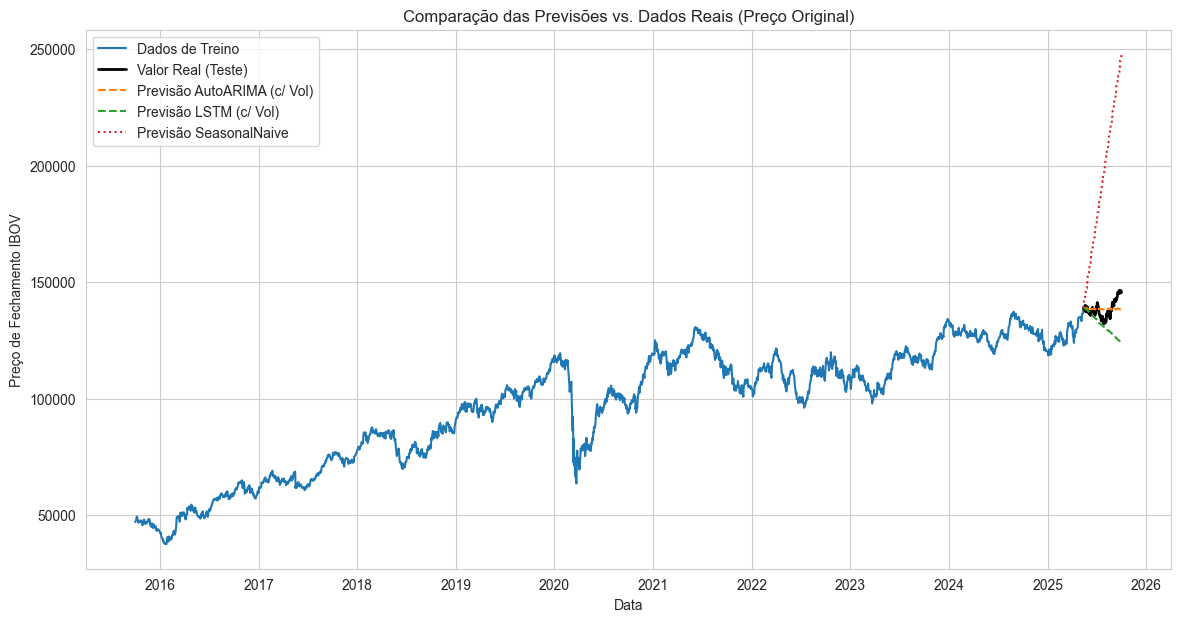

In [16]:
print("\n--- Avaliação Final dos Modelos (na escala original) ---")

# y_verdadeiro é o mesmo para todos
y_verdadeiro = y_teste_real

# Garantir que as previsões tenham o mesmo tamanho (H)
len_preds = H
y_verdadeiro_ajustado = y_verdadeiro[:len_preds]
previsoes_arima_real = previsoes_arima_real.values[:len_preds]
previsoes_naive_real = previsoes_naive_real.values[:len_preds]
previsoes_lstm_real = previsoes_lstm_real[:len_preds]

# Calcular métricas para o AutoARIMA (com Volume)
mae_arima = mean_absolute_error(y_verdadeiro_ajustado, previsoes_arima_real)
rmse_arima = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, previsoes_arima_real))
smape_arima = smape(y_verdadeiro_ajustado, previsoes_arima_real)

# Calcular métricas para o SeasonalNaive
mae_naive = mean_absolute_error(y_verdadeiro_ajustado, previsoes_naive_real)
rmse_naive = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, previsoes_naive_real))
smape_naive = smape(y_verdadeiro_ajustado, previsoes_naive_real)

# Calcular métricas para o LSTM (com Volume)
mae_lstm = mean_absolute_error(y_verdadeiro_ajustado, previsoes_lstm_real)
rmse_lstm = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, previsoes_lstm_real))
smape_lstm = smape(y_verdadeiro_ajustado, previsoes_lstm_real)

# --- Criar Tabela de Resultados ---
resultados = {
    'Modelo': ['SeasonalNaive', 'AutoARIMA (c/ Volume)', 'LSTM (c/ Volume)'],
    'MAE': [mae_naive, mae_arima, mae_lstm],
    'RMSE': [rmse_naive, rmse_arima, rmse_lstm],
    'SMAPE %': [smape_naive, smape_arima, smape_lstm]
}

tabela_resultados = pd.DataFrame(resultados).set_index('Modelo')
tabela_resultados = tabela_resultados.sort_values(by='SMAPE %')

print("\n--- Tabela de Resultados Finais (Comparação Justa) ---")
print(tabela_resultados.to_markdown(floatfmt=".2f"))

# --- Plotar Resultados Finais ---
plt.figure(figsize=(14, 7))
plt.title('Comparação das Previsões vs. Dados Reais (Preço Original)')
plt.plot(df_treino.index, df_treino['y'], label='Dados de Treino')
plt.plot(df_teste.index[:len_preds], y_verdadeiro_ajustado, label='Valor Real (Teste)', color='black', linewidth=2)
plt.plot(df_teste.index[:len_preds], previsoes_arima_real, label='Previsão AutoARIMA (c/ Vol)', linestyle='--')
plt.plot(df_teste.index[:len_preds], previsoes_lstm_real, label='Previsão LSTM (c/ Vol)', linestyle='--')
plt.plot(df_teste.index[:len_preds], previsoes_naive_real, label='Previsão SeasonalNaive', linestyle=':')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento IBOV')
plt.show()


--- Avaliação Final dos Modelos (na escala original) ---

--- Tabela de Resultados Finais (Comparação Justa) ---
| Modelo                |      MAE |     RMSE |   SMAPE % |
|:----------------------|---------:|---------:|----------:|
| AutoARIMA (c/ Volume) |  2938.00 |  3652.89 |      2.12 |
| LSTM (c/ Volume)      |  7083.86 |  9832.11 |      5.26 |
| SeasonalNaive         | 55063.33 | 62638.08 |     31.71 |


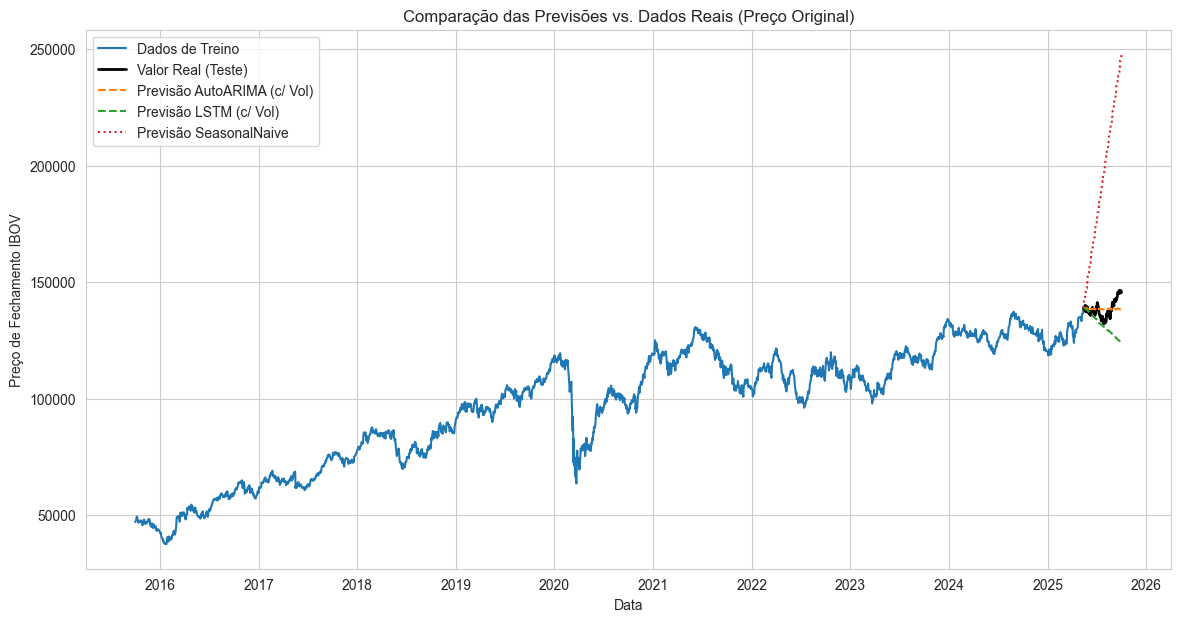

In [17]:
print("\n--- Avaliação Final dos Modelos (na escala original) ---")

# y_verdadeiro é o mesmo para todos
y_verdadeiro = y_teste_real # Já é um ndarray

# Garantir que as previsões tenham o mesmo tamanho (H)
len_preds = H
y_verdadeiro_ajustado = y_verdadeiro[:len_preds]

# --- CORREÇÃO ROBUSTA (À PROVA DE RE-EXECUÇÃO) ---

# Função helper para converter para numpy de forma segura
def to_numpy(data, length):
    """Converte um objeto (Series ou ndarray) para um ndarray fatiado."""
    if isinstance(data, pd.Series):
        # Se for uma Series, usa .values para converter
        return data.values[:length]
    elif isinstance(data, np.ndarray):
        # Se já for um ndarray, apenas fatia
        return data[:length]
    else:
        # Fallback para outros tipos
        return np.array(data)[:length]

# Agora usamos a função segura.
# Esta célula pode ser executada várias vezes sem erro.
arima_preds_ajustados = to_numpy(previsoes_arima_real, len_preds)
naive_preds_ajustados = to_numpy(previsoes_naive_real, len_preds)
lstm_preds_ajustados = to_numpy(previsoes_lstm_real, len_preds)

# --- Fim da Correção ---

# Calcular métricas para o AutoARIMA (com Volume)
mae_arima = mean_absolute_error(y_verdadeiro_ajustado, arima_preds_ajustados)
rmse_arima = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, arima_preds_ajustados))
smape_arima = smape(y_verdadeiro_ajustado, arima_preds_ajustados)

# Calcular métricas para o SeasonalNaive
mae_naive = mean_absolute_error(y_verdadeiro_ajustado, naive_preds_ajustados)
rmse_naive = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, naive_preds_ajustados))
smape_naive = smape(y_verdadeiro_ajustado, naive_preds_ajustados)

# Calcular métricas para o LSTM (com Volume)
mae_lstm = mean_absolute_error(y_verdadeiro_ajustado, lstm_preds_ajustados)
rmse_lstm = np.sqrt(mean_squared_error(y_verdadeiro_ajustado, lstm_preds_ajustados))
smape_lstm = smape(y_verdadeiro_ajustado, lstm_preds_ajustados)

# --- Criar Tabela de Resultados ---
resultados = {
    'Modelo': ['SeasonalNaive', 'AutoARIMA (c/ Volume)', 'LSTM (c/ Volume)'],
    'MAE': [mae_naive, mae_arima, mae_lstm],
    'RMSE': [rmse_naive, rmse_arima, rmse_lstm],
    'SMAPE %': [smape_naive, smape_arima, smape_lstm]
}

tabela_resultados = pd.DataFrame(resultados).set_index('Modelo')
tabela_resultados = tabela_resultados.sort_values(by='SMAPE %')

print("\n--- Tabela de Resultados Finais (Comparação Justa) ---")
print(tabela_resultados.to_markdown(floatfmt=".2f"))

# --- Plotar Resultados Finais (usando as variáveis corrigidas) ---
plt.figure(figsize=(14, 7))
plt.title('Comparação das Previsões vs. Dados Reais (Preço Original)')
plt.plot(df_treino.index, df_treino['y'], label='Dados de Treino')
plt.plot(df_teste.index[:len_preds], y_verdadeiro_ajustado, label='Valor Real (Teste)', color='black', linewidth=2)
plt.plot(df_teste.index[:len_preds], arima_preds_ajustados, label='Previsão AutoARIMA (c/ Vol)', linestyle='--')
plt.plot(df_teste.index[:len_preds], lstm_preds_ajustados, label='Previsão LSTM (c/ Vol)', linestyle='--')
plt.plot(df_teste.index[:len_preds], naive_preds_ajustados, label='Previsão SeasonalNaive', linestyle=':')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento IBOV')
plt.show()